### Dependencies

In [1]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import TimestampType
import pyspark.pandas as ps
import io
import requests

### Display Options

## Spark Session

In [7]:
# 공식 문서: compute.max_rows
# 1000행 이하라면 driver로 데이터를 가져와서 pandas API로 처리.
# 1000행 이상이면 pySpark로 처리
print(ps.options.compute.max_rows)

1000


## Spark Configuration

In [6]:
# spark.stop()
spark = SparkSession.builder \
        .appName("test") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.driver.memory", "6g") \
        .config("spark.executor.memory", "6g") \
        .config("spark.driver.maxResultSize", "4g") \
        .config("spark.sql.shuffle.partitions", "100") \
        .config('spark.driver.bindAddress', '127.0.0.1') \
        .getOrCreate()
        
# 1. 모든 설정 확인
all_configs = spark.sparkContext.getConf().getAll()
for key, value in all_configs:
    print(f"{key}: {value}")

# # 3. SQL 관련 설정만 확인
# sql_configs = spark.sql("SET -v").collect()
# for row in sql_configs:
#     print(f"{row['key']}: {row['value']}")

# # 4. Runtime에 설정된 값들 확인
# runtime_conf = spark.sparkContext._conf.getAll()
# for key, value in runtime_conf:
#     print(f"{key}: {value}")

25/02/03 03:09:13 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.Con

spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.app.name: test
spark.driver.port: 49434
spark.app.submitTime: 1738519734882
spark.driver.host: 218.38.137.2

### Data Loading

In [22]:
spark_df = spark.read.parquet("materials/data_engineering_course_materials/missions/W4/tlc/yellow_tripdata_2024-02.parquet")
# Unix timestamp 미지원으로 인해 sparkSQL로 변환
spark_df = spark_df.withColumn("tpep_pickup_datetime", 
                             spark_df["tpep_pickup_datetime"].cast(TimestampType())) \
                  .withColumn("tpep_dropoff_datetime", 
                             spark_df["tpep_dropoff_datetime"].cast(TimestampType()))
# Spark DataFrame을 pandas on Spark DataFrame으로 변환
psdf = ps.DataFrame(spark_df)


In [23]:
psdf.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 3007526 entries, 0 to 3007525
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               3007526 non-null  int32         
 1   tpep_pickup_datetime   3007526 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  3007526 non-null  datetime64[ns]
 3   passenger_count        2821916 non-null  int64         
 4   trip_distance          3007526 non-null  float64       
 5   RatecodeID             2821916 non-null  int64         
 6   store_and_fwd_flag     2821916 non-null  object        
 7   PULocationID           3007526 non-null  int32         
 8   DOLocationID           3007526 non-null  int32         
 9   payment_type           3007526 non-null  int64         
 10  fare_amount            3007526 non-null  float64       
 11  extra                  3007526 non-null  float64       
 12  mta_tax                30

25/02/03 03:10:07 WARN AttachDistributedSequenceExec: clean up cached RDD(79) in AttachDistributedSequenceExec(249)


In [24]:
psdf.shape

(3007526, 19)

In [25]:
for col in psdf.columns:
    print(col, ":", psdf[col].isnull().sum())

VendorID : 0
tpep_pickup_datetime : 0
tpep_dropoff_datetime : 0
passenger_count : 185610
trip_distance : 0
RatecodeID : 185610
store_and_fwd_flag : 185610
PULocationID : 0
DOLocationID : 0
payment_type : 0
fare_amount : 0
extra : 0
mta_tax : 0
tip_amount : 0
tolls_amount : 0
improvement_surcharge : 0
total_amount : 0
congestion_surcharge : 185610
Airport_fee : 185610


In [26]:
psdf[psdf['passenger_count'].isnull()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2821916,1,2024-02-01 00:05:19,2024-02-01 00:10:43,NaN,0.00,NaN,None,161,229,0,7.83,0.00,0.5,0.00,0.00,1.0,11.83,NaN,NaN
2821917,1,2024-02-01 00:03:28,2024-02-01 00:23:16,NaN,0.00,NaN,None,231,239,0,24.00,2.00,0.5,12.05,0.00,1.0,44.05,NaN,NaN
2821918,1,2024-02-01 00:46:48,2024-02-01 00:58:19,NaN,0.00,NaN,None,239,161,0,9.95,0.00,0.5,0.00,0.00,1.0,13.95,NaN,NaN
2821919,2,2024-02-01 00:38:38,2024-02-01 00:43:44,NaN,0.81,NaN,None,114,107,0,6.83,0.00,0.5,0.00,0.00,1.0,10.83,NaN,NaN
2821920,1,2024-02-01 00:47:20,2024-02-01 00:57:28,NaN,1.90,NaN,None,231,249,0,10.16,0.00,0.5,0.00,0.00,1.0,14.16,NaN,NaN
2821921,2,2024-02-01 00:03:54,2024-02-01 00:15:56,NaN,2.39,NaN,None,239,230,0,12.96,0.00,0.5,0.00,0.00,1.0,16.96,NaN,NaN
2821922,2,2024-02-01 00:10:06,2024-02-01 00:24:02,NaN,2.45,NaN,None,170,50,0,13.91,0.00,0.5,0.00,0.00,1.0,17.91,NaN,NaN
2821923,2,2024-02-01 00:51:25,2024-02-01 01:04:18,NaN,1.41,NaN,None,231,249,0,11.74,0.00,0.5,1.57,0.00,1.0,17.31,NaN,NaN
2821924,2,2024-02-01 00:16:14,2024-02-01 00:30:18,NaN,2.65,NaN,None,262,142,0,13.61,0.00,0.5,0.00,0.00,1.0,17.61,NaN,NaN
2821925,1,2024-02-01 00:46:31,2024-02-01 00:55:57,NaN,1.40,NaN,None,246,50,0,10.00,1.00,0.5,2.25,0.00,1.0,17.25,NaN,NaN


## Data Cleaning

In [27]:
null_counts = psdf.isna().sum()
print("\nNull 값 개수:")
print(null_counts)


Null 값 개수:
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          185610
trip_distance                 0
RatecodeID               185610
store_and_fwd_flag       185610
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     185610
Airport_fee              185610
dtype: int64


In [28]:
psdf = psdf.dropna()

In [29]:
for col in psdf.columns:
    if (
        psdf[col].dtype == np.float64
        or psdf[col].dtype == np.int32
        or psdf[col].dtype == np.int64
        ):
        print(col, ":", psdf[psdf[col] < 0].shape[0])

VendorID : 0


passenger_count : 0


trip_distance : 0


RatecodeID : 0


PULocationID : 0


DOLocationID : 0


payment_type : 0


fare_amount : 35999


extra : 18096


mta_tax : 35052


tip_amount : 109


tolls_amount : 2260


improvement_surcharge : 36078


total_amount : 36078


congestion_surcharge : 29866
Airport_fee : 4801


In [30]:
# 방법 1: 조건식을 이용한 필터링. 그런데 오버헤드가 나서 connect가 끊겼음.
# condition = (psdf['fare_amount'] > 0) & \
#            (psdf['extra'] >= 0) & \
#            (psdf['mta_tax'] >= 0) & \
#            (psdf['tip_amount'] >= 0) & \
#            (psdf['tolls_amount'] >= 0) & \
#            (psdf['improvement_surcharge'] >= 0) & \
#            (psdf['total_amount'] > 0) & \
#            (psdf['congestion_surcharge'] >= 0) & \
#            (psdf['Airport_fee'] >= 0)

# 각 조건이 Python 객체로 평가되어 메모리에 저장
# 조건들이 한번에 결합되어 단일 연산으로 처리
# 복잡한 조건의 경우 메모리 사용량이 매우 커질 수 있음

# psdf = psdf[condition]

# 방법 2: query 메서드 사용
condition = '''
    fare_amount > 0 and total_amount > 0 and
    extra >= 0 and mta_tax >= 0 and tip_amount >= 0 and
    tolls_amount >= 0 and improvement_surcharge >= 0 and
    congestion_surcharge >= 0 and Airport_fee >= 0
'''
psdf = psdf.query(condition)
psdf.shape

(2785158, 19)

### Average Trip Duration

In [31]:
psdf['trip_duration'] = psdf['tpep_dropoff_datetime'] - psdf['tpep_pickup_datetime']
avg_trip_dur = psdf['trip_duration'].mean()

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/data_type_ops/datetime_ops.py:71: UserWarning: Note that there is a behavior difference of timestamp subtraction. The timestamp subtraction returns an integer in seconds, whereas pandas returns 'timedelta64[ns]'.
  warnings.warn(msg, UserWarning)


In [32]:
minutes = int(avg_trip_dur // 60)
seconds = int(avg_trip_dur % 60)
print(f"평균 여행 시간: {minutes}분 {seconds}초")

평균 여행 시간: 16분 0초


In [33]:
avg_trip_dist = psdf['trip_distance'].mean()
print(f"평균 여행 거리: {avg_trip_dist:.2f}마일")

평균 여행 거리: 3.37마일


### Peak Hours
- 시간별로 피크 시간을 찾아내자.
- 시작이 많이 일어난 것이 피크 시간이라고 하자.
- 24시간을 24개의 구간으로 나누어서 각 구간별로 피크 시간을 찾아내자.
- 주말과 평일을 나누어서 각각의 피크 시간을 찾아내자.

In [34]:
psdf.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration'],
      dtype='object')

In [35]:
psdf['pickup_hour'] = psdf['tpep_pickup_datetime'].dt.hour

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


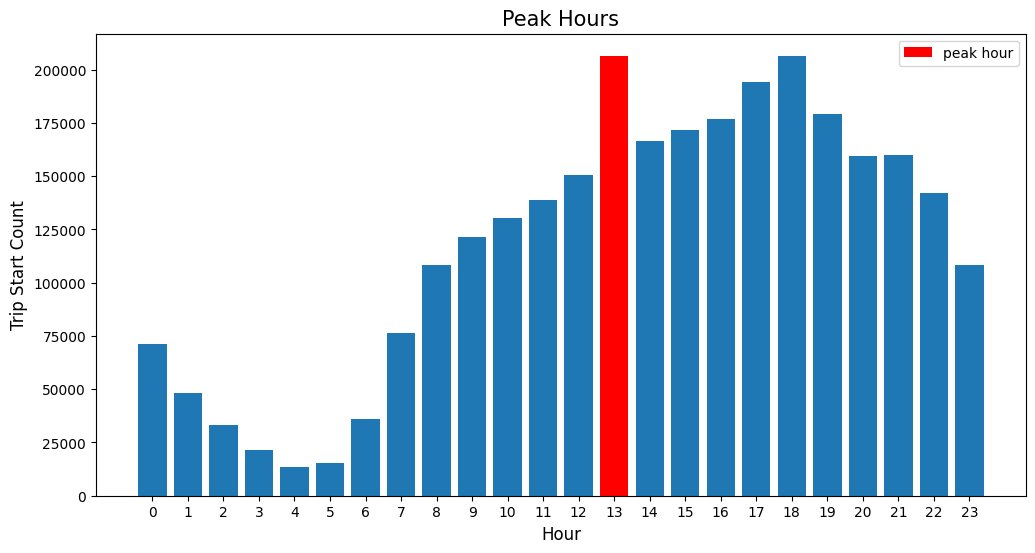

In [36]:
import matplotlib.pyplot as plt

# 변환은 pandas on Spark DataFrame
hourly_counts = psdf.groupby('pickup_hour') \
        .size() \
        .reset_index(name='count') \
        .sort_values(by='pickup_hour')

# 시각화는 pandas DataFrame과 numpy array
plt.figure(figsize=(12, 6))
peak_hour_idx = hourly_counts['count'].idxmax()
# 충분히 작은 데이터이기에 pandas DataFrame과 numpy array로 변환하여 시각화
plt.bar(hourly_counts['pickup_hour'].to_numpy(), hourly_counts['count'].to_numpy())
plt.bar(peak_hour_idx, hourly_counts['count'].max(), color='red', label='peak hour')
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.xlabel("Hour", size=12)
plt.ylabel("Trip Start Count", size=12)
plt.title("Peak Hours", size=15)

plt.show()


## 기상 데이터 및 location ID 로드

In [37]:
nyc_boroughs = [
    'Manhattan', 'Queens', 'Brooklyn', 'Staten Island', 'Bronx',
    'EWR' # Newark Liberty International Airport
    
]

taxi_zone_lookup_psdf = ps.read_csv("materials/data_engineering_course_materials/missions/W4/tlc/taxi_zone_lookup.csv")
central_park_isd_psdf = ps.read_csv("materials/data_engineering_course_materials/missions/W4/tlc/central_park_ISD_2024.csv")
jfk_isd_psdf = ps.read_csv("materials/data_engineering_course_materials/missions/W4/tlc/JFK_ISD_2024.csv")
la_guardia_isd_psdf = ps.read_csv("materials/data_engineering_course_materials/missions/W4/tlc/LaGuardia_ISD_2024.csv")
ewr_isd_psdf = ps.read_csv("materials/data_engineering_course_materials/missions/W4/tlc/EWR_ISD_2024.csv")

{
    'Brooklyn': 'central park',
    'Queens': 'jfk',
    'Manhattan': 'central park',
    'Staten Island': 'central park',
    'Bronx': 'la guardia airport',
    'EWR': 'newark airport'
}


/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


{'Brooklyn': 'central park',
 'Queens': 'jfk',
 'Manhattan': 'central park',
 'Staten Island': 'central park',
 'Bronx': 'la guardia airport',
 'EWR': 'newark airport'}

### PULocationID로 taxi zone ID 매핑 -> 해당하는 borough의 날씨 데이터 중 tpep_pickup_datetime 사이에 있는 날씨 데이터로 join

In [38]:
# 뉴욕시의 borough를 join
# 그냥 다른 dataframe을 join하면 compute.ops_on_diff_frames을 true로 설정해야함.
# 그러면 다양한 문제 발생 가능


# 임시 테이블 생성
psdf.to_spark().createOrReplaceTempView("trips")
taxi_zone_lookup_psdf.to_spark().createOrReplaceTempView("zones")
# SQL 쿼리로 조인 수행
result = ps.sql("""
    SELECT t.*, z.Borough as location
    FROM trips t
    JOIN zones z ON t.PULocationID = z.LocationID
""")
psdf = ps.DataFrame(result)



/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [39]:
psdf['location'].value_counts()

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


Manhattan        2509442
Queens            239426
Brooklyn           19686
Unknown             9380
Bronx               5580
N/A                 1327
EWR                  278
Staten Island         39
Name: location, dtype: int64

In [40]:
psdf.to_spark().createOrReplaceTempView("trips")
result = ps.sql("""
                SELECT *
                    FROM trips
                WHERE location IN ('Manhattan', 'Brooklyn', 'Staten Island')
                """)
temp = ps.DataFrame(result)
print(temp['location'].value_counts())
psdf['location'].value_counts()

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


Manhattan        2509442
Brooklyn           19686
Staten Island         39
Name: location, dtype: int64


Manhattan        2509442
Queens            239426
Brooklyn           19686
Unknown             9380
Bronx               5580
N/A                 1327
EWR                  278
Staten Island         39
Name: location, dtype: int64

In [82]:
# location과 시간대별마다 다른 ISD를 join

# location과 시간대별로 ISD를 join
psdf.to_spark().createOrReplaceTempView("trips")
central_park_isd_psdf.to_spark().createOrReplaceTempView("central_park_isd")

start_date = '2024-02-01'
end_date = '2024-03-01' # between은 끝 02-29:00:00:00까지 포함. 29일은 반영되지 않음.

query = f"""
WITH filtered_trips AS (
    SELECT *
    FROM trips
    WHERE location IN ('Manhattan', 'Brooklyn', 'Staten Island', 'Unknown', 'N/A')
),
filtered_weather AS (
    SELECT TMP, AA1, WND, DATE
    FROM central_park_isd
    WHERE DATE BETWEEN '{start_date}' AND '{end_date}'
        AND REPORT_TYPE = 'FM-15'
)
SELECT 
    t.*,
    w.TMP,
    w.AA1,
    w.WND
FROM filtered_trips t
JOIN filtered_weather w
    ON date_format(t.tpep_pickup_datetime, 'yyyy-MM-dd HH') = date_format(w.DATE, 'yyyy-MM-dd HH') 
"""

# spark.sql() 사용
result = spark.sql(query)
climate_tlc_psdf = ps.DataFrame(result)

# Queens와 JFK ISD를 join
jfk_isd_psdf.to_spark().createOrReplaceTempView("jfk_isd")
query = f"""
WITH filtered_trips AS (
    SELECT *
    FROM trips
    WHERE location = 'Queens'
),
filtered_weather AS (
    SELECT TMP, AA1, WND, DATE
    FROM jfk_isd
    WHERE DATE BETWEEN '{start_date}' AND '{end_date}'
        AND REPORT_TYPE = 'FM-15'
)
SELECT 
    t.*,
    w.TMP,
    w.AA1,
    w.WND
FROM filtered_trips t
LEFT OUTER JOIN filtered_weather w
    ON date_format(t.tpep_pickup_datetime, 'yyyy-MM-dd HH') = date_format(w.DATE, 'yyyy-MM-dd HH')
"""

# spark.sql() 사용
result = spark.sql(query)
climate_tlc_psdf = climate_tlc_psdf.append(ps.DataFrame(result))

# Bronx와 LaGuardia ISD를 join
la_guardia_isd_psdf.to_spark().createOrReplaceTempView("la_guardia_isd")
query = f"""
WITH filtered_trips AS (
    SELECT *
    FROM trips
    WHERE location = 'Bronx'
),
filtered_weather AS (
    SELECT TMP, AA1, WND, DATE
    FROM la_guardia_isd
    WHERE DATE BETWEEN '{start_date}' AND '{end_date}'
        AND REPORT_TYPE = 'FM-15'
)
SELECT 
    t.*,
    w.TMP,
    w.AA1,
    w.WND
FROM filtered_trips t
LEFT OUTER JOIN filtered_weather w
    ON date_format(t.tpep_pickup_datetime, 'yyyy-MM-dd HH') = date_format(w.DATE, 'yyyy-MM-dd HH')
"""

# spark.sql() 사용
result = spark.sql(query)
climate_tlc_psdf = climate_tlc_psdf.append(ps.DataFrame(result))

# EWR과 EWR ISD를 join
ewr_isd_psdf.to_spark().createOrReplaceTempView("ewr_isd")
query = f"""
WITH filtered_trips AS (
    SELECT *
    FROM trips
    WHERE location = 'EWR'
),
filtered_weather AS (
    SELECT TMP, AA1, WND, DATE
    FROM ewr_isd
    WHERE DATE BETWEEN '{start_date}' AND '{end_date}'
        AND REPORT_TYPE = 'FM-15'
)
SELECT 
    t.*,
    w.TMP,
    w.AA1,
    w.WND
FROM filtered_trips t
LEFT OUTER JOIN filtered_weather w
    ON date_format(t.tpep_pickup_datetime, 'yyyy-MM-dd HH') = date_format(w.DATE, 'yyyy-MM-dd HH')
"""

# spark.sql() 사용
result = spark.sql(query)
climate_tlc_psdf = climate_tlc_psdf.append(ps.DataFrame(result))

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/frame.py:8890: FutureWarning: The DataFrame.append method is deprecated and will be removed in 4.0.0. Use pyspark.pandas.concat instead.
  warnings.warn(


In [ ]:
climate_tlc_psdf.shape

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


Manhattan        2509429
Queens            239426
Brooklyn           19686
Unknown             9379
Bronx               5599
N/A                 1327
EWR                  280
Staten Island         39
Name: location, dtype: int64

In [84]:
print(psdf.shape)
psdf['location'].value_counts()

/Users/admin/workspace/python/DE/.venv/lib/python3.10/site-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


(2785158, 22)


Manhattan        2509442
Queens            239426
Brooklyn           19686
Unknown             9380
Bronx               5580
N/A                 1327
EWR                  278
Staten Island         39
Name: location, dtype: int64

### 날씨 데이터와 택시 데이터 분석
- 기온과 시간별 탑승 건수의 상관관계
- 강수량과 시간별 탑승 건수의 상관관계
- 기온과 tip의 상관관계
- 강수량과 tip의 상관관계
- 기온과 total_amount의 상관관계
- 강수량과 total_amount의 상관관계

In [86]:
climate_tlc_psdf.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration',
       'pickup_hour', 'location', 'TMP', 'AA1', 'WND'],
      dtype='object')